# Do some imports

In [1]:
!pip install --user pandas
!pip install --user scikit-learn
!pip install --user tqdm

from typing import List
import numpy as np
import pandas as pd
#

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from brevitas.nn import QuantIdentity, QuantConv2d, QuantReLU, QuantLinear, QuantHardTanh
from brevitas.core.quant import QuantType

from dataloader import UNSW_NB15
from dataloader_quantized import UNSW_NB15_quantized

### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [2]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [3]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define the Neural Network class

In [4]:
class QuantLeNet(nn.Module):
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super(QuantLeNet, self).__init__()
        self.fc1   = QuantLinear(input_size, hidden1, bias=True, weight_bit_width=8)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.relu1 = QuantReLU(bit_width=8)
        
        self.fc2   = QuantLinear(hidden1, hidden2, bias=True, weight_bit_width=8)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.relu2 = QuantReLU(bit_width=8)
        
        self.fc3   = QuantLinear(hidden2, hidden3, bias=True, weight_bit_width=8)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.relu3 = QuantReLU(bit_width=8)
        
        self.fc4   = QuantLinear(hidden3, num_classes, bias=False, weight_bit_width=8)
        self.batchnorm4 = nn.BatchNorm1d(num_classes)     

    def forward(self, x):
        fc1 = self.fc1(x)
        b1 = self.batchnorm1(fc1)
        relu1 = self.relu1(b1)
        
        fc2 = self.fc2(relu1)
        b2 = self.batchnorm2(fc2)
        relu2 = self.relu2(b2)

        fc3 = self.fc3(relu2)
        b3 = self.batchnorm3(fc3)
        relu3 = self.relu3(b3)
        
        fc4 = self.fc4(relu3)
        b4 = self.batchnorm4(fc4)

        return b4


### Define Train,   Test   and    Display_Loss_Plot    methods

In [5]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):        
        # get the inputs; data is a list of [inputs, target ( or labels)]
        inputs , target = data
        optimizer.zero_grad()   
                
        #FORWARD PASS
        output = model(inputs.float())
        loss = criterion(output, target.unsqueeze(1))
        
        #BACKWARD AND OPTIMIZE        
        loss.backward()
        optimizer.step()
        

        # PREDICTIONS
        #pred = np.round(output.detach().numpy())
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
    #print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    return losses

In [6]:
#TESTING THE MODEL
def test(model, device, test_loader):    
    model.eval()   #model in eval mode skips Dropout etc
    y_true = []
    y_pred = []
   
    with torch.no_grad(): # set the requires_grad flag to false as we are in the test mode
        for data in test_loader:
            
            #LOAD THE DATA IN A BATCH
            inputs ,target = data
            
            # the model on the data
            output = torch.sigmoid(model(inputs.float()))  
            
            #PREDICTIONS
            pred = np.round(output)
            #pred = output.detach().numpy() > 0.5 
            #pred = pred * 1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [7]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Cross entropy loss')
    plt.show()

# Define some parameters first

In [31]:
device = 'cpu'
input_size = 593      #
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

num_epochs = 5
batch_size = 5000 
lr = 0.001        

# Initialize Neural Network class

In [32]:
model = QuantLeNet(input_size, hidden1, hidden2, hidden3, num_classes)

# Define loss and optimizer 

In [33]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Initialize UNSW_NB15 class

In [39]:
#Get the Quantized versions 
train_quantized_dataset = UNSW_NB15_quantized(file_path_train='data/UNSW_NB15_training-set.csv', \
                                              file_path_test = "data/UNSW_NB15_testing-set.csv", \
                                              train=True)
train_quantized_loader = DataLoader(train_quantized_dataset, batch_size=batch_size, shuffle=True)

test_quantized_dataset = UNSW_NB15_quantized(file_path_train='data/UNSW_NB15_training-set.csv', \
                                              file_path_test = "data/UNSW_NB15_testing-set.csv", \
                                              train=False)
test_quantized_loader = DataLoader(test_quantized_dataset, batch_size=batch_size, shuffle=True)

torch.Size([175341, 594])
torch.Size([82332, 594])


# Lets Train, Test the model and see the loss

In [35]:
train_loader = train_quantized_loader
test_loader = test_quantized_loader

In [36]:
running_loss = []
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, device, train_loader, optimizer,criterion)
        running_loss.append(loss_epoch)
#Save the model!!
torch.save(model.state_dict(), "MLP_model")

100%|██████████| 5/5 [00:31<00:00,  6.27s/it]


In [37]:
#model.load_state_dict(torch.load("MLP_model"))
test(model,device,test_loader)

0.8870427051450226

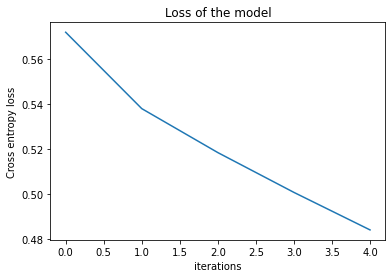

In [38]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

**********************************************************************************************************************

# Results

    num_epochs = 5
    batch_size = 5000 
    lr = 0.001
    accuracy on test set = 0.8913788077539717
    file: data/MLP_model_0.8913788077539717